In [1]:
from vowpalwabbit import pyvw
from newsenv import news
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={} location={} interest={}\n".format(context["user"], context["time_of_day"],context["location"],context["interest"])    
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [3]:
def sample_custom_pmf(pmf):    
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob
        
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return chosen_action_index,actions[chosen_action_index], prob

In [4]:
def run_simulation(vw,env,num_iterations,actions,do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        
        context = env.get_context()
        action_i,action, prob = get_action(vw, context, actions)        
        cost = env.get_cost(context, action_i)
        cost_sum += cost
        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)           
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [5]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

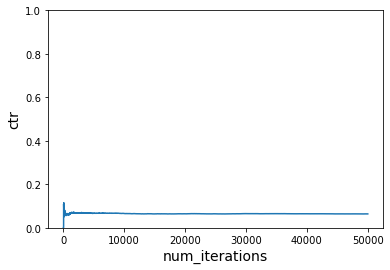

In [6]:
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]
env=news(actions)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2 -l 1e-4")
num_iterations = 50000
ctr = run_simulation(vw,env,num_iterations,actions)
plot_ctr(num_iterations, ctr)